<a href="https://colab.research.google.com/github/okhko/practicum_portfolio_ru/blob/main/Project17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Мэтчинг товаров.

</center>

## Описание проекта.

- __Задача.__
  - Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`.
<br><br>
- __Метрика.__
  - Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$
- __Данные.__
  - __Источник:__ https://disk.yandex.ru/d/BBEphK0EHSJ5Jw
  - `base.csv` : база данных всех товаров.
    - Насчитывает 72 признака и 2918139 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br><br>
  - `train.csv` : обучающая выборка, взятая из `base.csv`.
    - Насчитывает 73 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
    - Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`
<br><br>
  - `validatation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
    - Насчитывает 72 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br><br>

  - `validation_answer.csv` : база данных, с разметкой похожих для товаров из `validatation.csv`.
    - Насчитывает 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br>

- __План работы__:
    - [Загрузка библиотек.](#Загрузка-библиотек.)
    - [Установка параметров проекта.](#Установка-параметров-проекта.)
    - [Ознакомление с данными, ИАД.](#Ознакомление-с-данными,-ИАД.)
    - [Предобработка данных.](#Предобработка-данных.)
    - [Базовые модели.](#Базовые-модели.)
    - [Вычисление оптимального кол-ва кластеров.](#Вычисление-оптимального-кол-ва-кластеров.)
    - [Тесты параметров `FAISS` / `ANNOY`.](#Тесты-параметров-FAISS-/-ANNOY.)
    - [Вложенный `KMeans` + `NEarestNeighbors`.](#Вложенный-KMeans-+-NearestNeighbors.)

## Загрузка библиотек.

In [ ]:
!pip install py7zr

In [ ]:
import py7zr
import pandas as pd

In [ ]:
### os для обращения к среде разработки и requests для интернет запросов.
import os, requests
# urlencoed для кодирования ссылок.
from urllib.parse import urlencode
### zipfile для распаковки zip
import zipfile
### perf_counter для контроля времение исполнения.
from time import perf_counter
### numpy для вычислений.
import numpy as np
### pandas для работы с датафреймами
import pandas as pd

### Визуализация.
# matplotlib для визуализации.
import matplotlib.pyplot as plt

# seaborn для визуализации.
import seaborn as sns
# missingno для построения графика пропусков.
!pip install missingno -q
import missingno as msno

### Тесты для сравнения выборок.
from scipy.stats import kstest
from scipy.stats import zscore

### Методы и классы для работы с моделями.
# Разделение выборок.
from sklearn.model_selection import train_test_split
# robustscaler устойчивый к выбросам
from sklearn.preprocessing import (RobustScaler,
                                   StandardScaler,
                                   QuantileTransformer)
from sklearn.metrics import (silhouette_score,
                             davies_bouldin_score)

### Модули для контроля времени и хода исполнения ячеек.
## tqdm для контроля выполнения ячеек;
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from tqdm.contrib.itertools import product
# Для подавления FutureWarning от Pandas.
from warnings import simplefilter

## Модели.
# Кластеризация.
from sklearn.cluster import KMeans, MiniBatchKMeans
# Дерево решений.
from sklearn.tree import DecisionTreeRegressor
# NeirestNeighbors.
from sklearn.neighbors import NearestNeighbors

# FAISS.
!pip install faiss-cpu -q
import faiss
# ANNOY.
!pip install annoy -q
from annoy import AnnoyIndex

### HTML для настройки отображения эл-тов.
from IPython.core.display import HTML

## Установка параметров проекта.

In [ ]:
# Установим количество искомых похожих объектов по условию задачи.
K = 5

# Установим начальное значение генератора псевдослучайных чисел.
SEED = 42
np.random.seed(SEED)

# Установим стиль отображения заголовков таблиц.
styles = [
    dict(selector='caption',
         props=[('text-align', 'center'),
                ('font-size', '110%'),
                ('font-weight', 'bold'),
                ('white-space', 'pre-wrap')]),
    dict(selector="th",
         props=[('max-width', '250px')])
    ]

# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Игнорируем FutureWarning от Pandas.
from warnings import simplefilter
simplefilter(action='ignore', category=Warning)

# Вывод нескольких таблиц рядом.
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption).to_html()
        output += tablespacing * "\xa0"
    display(HTML(output))

# # Определение места хранения файлов отдельно для Google Colab.
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import drive
    drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Загрузка данных.

In [ ]:
! gdown '1uJnHE-sRSM55s8cRPgC6VdhOJU_cQfyF'

Downloading...
From (original): https://drive.google.com/uc?id=1uJnHE-sRSM55s8cRPgC6VdhOJU_cQfyF
From (redirected): https://drive.google.com/uc?id=1uJnHE-sRSM55s8cRPgC6VdhOJU_cQfyF&confirm=t&uuid=e3f443d2-e1d5-4cb7-b9f3-189fe38eab7a
To: /content/data.7z
100% 952M/952M [00:15<00:00, 61.9MB/s]


In [ ]:
archive_path = '/content/data.7z' # Путь к вашему архиву
extract_path = '/content/' # Папка, куда вы хотите извлечь файлы

with py7zr.SevenZipFile(archive_path, mode='r') as z:
    z.extractall(path=extract_path)

# Убедитесь, что указываете правильный путь к файлу после его извлечения
# Загрузка данных
df_base = pd.read_csv('/content/base.csv')
df_train = pd.read_csv('/content/train.csv')
df_val = pd.read_csv('/content/validation.csv')
df_val_answer = pd.read_csv('/content/validation.csv')

In [ ]:
df_base.info()
df_base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.620390,-176.61588,-529.762412,-100.565520,-125.31733,-57.199104,

In [ ]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-24.104229,75.142590,-207.34506,93.436935,51.505203,-135.47598,9

In [ ]:
df_val.info()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255370,44.165030,-135.29533,-19.508160,-106.674866,-127.978884,-1

In [ ]:
df_val_answer.info()
df_val_answer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255370,44.165030,-135.29533,-19.508160,-106.674866,-127.978884,-1

In [ ]:
# Функция загрузки и записи в переменные любого количества датасетов
# по ссылкам или пути с проверкой адреса/пути.
def fetch_datasets(pths, separator=',', index_col=None, dtype=None):
    '''
    Fetches and assigns datasets to variables.
    Arguments:
    - pths: str, list. Full string path in quotes or list of links or
    list of file paths as list of strings.
    - separator: str, default=','. Separator as a string.
    - Example: ('/datasets/file.csv' or ['https://datasets/file.csv'], 't').
    '''

    # Переведём путь в список при необходимости.
    pths = [pths] if isinstance(pths, str) else pths

    print("\n\033[1m",
          'Начало загрузки и записи датасетов в переменные:',
          "\033[0m")

    for pth in tqdm(pths):
        # Запишем название и расширение файла.
        full_name = os.path.basename(pth)
        name, extension = os.path.splitext(full_name)

        # Проверим ссылку и запишем датасет в переменную.
        if 'http' in pth:
            # Воспользуемся try/except для непредвиденных ошибок.
            try:
                # Проверим корректность ссылки.
                if requests.get(pth).status_code == 200:
                    # Создадим переменную и запишем в неё датафрейм.
                    globals()[name.lower()] = pd.read_csv(
                        filepath_or_buffer=pth,
                        sep=separator,
                        index_col=index_col,
                        dtype=dtype
                        )
                    print(f'Файл {full_name} прочитан и записан в переменную ',
                          f'"{name.lower()}". \nПуть к файлу: \n{pth}')
                    print('~' * 60)
                else:
                    print(f'Ошибка чтения файла по пути: {pth}')
                    print('~' * 60)
            except:
                print(f'Ошибка чтения файла по пути: {pth}')

        # Проверим путь и запишем датасет в переменную.
        elif os.path.exists(pth):
            # Создадим переменную и запишем в неё датафрейм.
            globals()[name.lower()] = pd.read_csv(
                filepath_or_buffer=pth,
                sep=separator,
                index_col=index_col,
                dtype=dtype
                )
            print(f'Файл {full_name} прочитан и записан в переменную ',
                  f'"{name.lower()}". \nПуть к файлу: \n{pth}')
            print('~' * 60)

        else:
            print(f'Ошибка чтения файла по пути: {pth}.')
            print('~' * 60)

In [ ]:
# Определим словари типов данных для датафреймов `df_base`, `df_train` и
# `df_val`.
dict_base = {str(i) : 'float32' for i in range(72)}
dict_train = dict_base.copy()
dict_train['Target'] = 'str'
dict_val = {'id' : 'str'}
dict_val.update(dict_base)

# Прочитаем и запишем датасеты в переменные.
if os.getenv("COLAB_RELEASE_TAG"):
    fetch_datasets('/content/drive/Othercomputers/My_Computer/JupiterNB/'+
                   'datasets/matching_base.csv',
                   index_col=0, dtype=dict_base)
    fetch_datasets('/content/drive/Othercomputers/My_Computer/JupiterNB/'+
                   'datasets/matching_train.csv',
                   index_col=0, dtype=dict_train)
    fetch_datasets('/content/drive/Othercomputers/My_Computer/JupiterNB/'+
                   'datasets/matching_validation.csv',
                   index_col=0, dtype=dict_val)
    fetch_datasets('/content/drive/Othercomputers/My_Computer/JupiterNB/'+
                   'datasets/matching_validation_answer.csv', index_col=0)
else:
    fetch_datasets('./datasets/matching_base.csv',
                   index_col=0, dtype=dict_base)
    fetch_datasets('./datasets/matching_train.csv',
                   index_col=0, dtype=dict_train)
    fetch_datasets('./datasets/matching_validation.csv',
                    index_col=0, dtype=dict_val)
    fetch_datasets('./datasets/matching_validation_answer.csv',
                   index_col=0)


 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Ошибка чтения файла по пути: /content/drive/Othercomputers/My_Computer/JupiterNB/datasets/matching_base.csv.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Ошибка чтения файла по пути: /content/drive/Othercomputers/My_Computer/JupiterNB/datasets/matching_train.csv.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Ошибка чтения файла по пути: /content/drive/Othercomputers/My_Computer/JupiterNB/datasets/matching_validation.csv.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Ошибка чтения файла по пути: /content/drive/Othercomputers/My_Computer/JupiterNB/datasets/matching_validation_answer.csv.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


- Переименуем переменные.

In [ ]:
# df_base = matching_base
# df_train = matching_train
# df_val = matching_validation
# df_val_answer = matching_validation_answer

NameError: name 'matching_base' is not defined

## Ознакомление с данными, ИАД.

### Вспомогательные функции.
Введём вспомогательные функции:
- функцию поиска репрезентативного процента выборки;
- функцию вычисления процента выбросов;
- функцию вывода графиков ИАД.

#### Функция поиска репрезентативного процента выборки.
- Функция принимает датафрейм и список долей для перебора.
- Функция проводит двусторонние тесты Колмогорова-Смирнова для каждого признака в основной выборке и подвыборке.
- Функция выводит процент объектов для репрезантивной выборки, если распределения всех признаков идентичны.

In [ ]:
# Функция поиска репрезентативного процента выборки.
def sample_kstest(x, y = None, frac=None):
    '''
    Calculalates the representative sample percentage by conducting
    Kolmogorov-Smirnov test for two dataframes or tests two distributions for
    equality.
    Arguments:
    - x: dataframe/series/array.
    - y: series/array.
    '''

    if (isinstance(x, pd.DataFrame) and \
        not y and \
        isinstance(frac, (list, np.ndarray))):
        fracs = frac
        np.random.seed(42)

        for frac in fracs:
            i = 0
            y = x.sample(frac=frac, random_state=SEED)
            for col in x.columns:
                _, p_value = kstest(x[col], y[col])
                if p_value < .05:
                    break
                else:
                    i += 1
                if i == len(x.columns):
                    print('Распределения признаков в выборках одинаковы при'+
                    f' выборке {frac:.0%} объектов.')
                    return
        print('Найти репрезентативный процент выборки не удалось.')
    else:
        _, p_value = kstest(x, y)
        if p_value < .05:
            print(f'Распределение признаков различны.')
        else:
            print(f'Распределение признаков одинаковы.')

#### Функция вычисления процента выбросов.
- Функция примет
  - признак;
  - метку вывода пограничных значений;
  - коэффициент для рассчёта пограничных значений<br>
    (по умолчанию коэффициент = 1.5, что соответствует "усам" диаграммы размаха и 2.7$\sigma$).
- Функция вычислит и выведет процент значений вне границ, и при необходимости, пограничные значения.

In [ ]:
# Введём функцию рассчёта и вывода процентов выбросов для отобранных
# признаков.
def get_outliers_ratio(col: pd.Series, whiskers=False, iqr_coeff=1.5):
    '''
    Calculates boxplot whiskers and outlier percentage. Optionaly returns
    whiskers.
    Arguments:
    - data: pd.DataFrame() | pd.Series(). Either DataFrame or Series variable.
    - whiskers: bool. whether to return whiskers (True) or not.
    - coeff: float. Default - 1.5 for 2.7 sigma. Can be changed to 1.7 for
      3 sigma.
    '''
    # Вычислим интерквартильный размах.
    distr_iqr = col.quantile(.75) - col.quantile(.25)
    # Вычислим границы.
    whisker_upp = col.quantile(.75) + iqr_coeff * distr_iqr
    whisker_low = col.quantile(.25) - iqr_coeff * distr_iqr
    # Если усы границы экстремумы, приравняем их.
    if whisker_upp >= col.max():
        whisker_upp = col.max()
    if whisker_low <= col.min():
        whisker_low = col.min()
    else:
        pass
    # Вычислим процент выбросов.
    outliers_ratio = (
        (col[col > whisker_upp].count() +
         col[col < whisker_low].count()) /
        len(col)
        )
    # Выведем границы и процент выбросов если необходимо.
    if whiskers:
        return whisker_low, whisker_upp, outliers_ratio
    # Выведем только процент выбросов.
    else:
        return outliers_ratio

#### Функция вывода графиков ИАД.
- Функция примет
  - датафрейм;
  - опционально:
    - название датайрейма;
    - процент подвыборки;
    - метку вывода процентов выбросов;
    - коэффициент для рассчёта выбросов;
- Функция выведет гистограммы и диаграммы размаха для всех признаков датафрейма.

In [ ]:
# Функция вывода графиков ИАД.
def get_eda_plots(df : pd.DataFrame, name = None,
                  sample_frac = None, seed = SEED,
                  outliers = True, iqr_coeff = 1.5):
    '''
    Plots histograms and boxplot diagrams for all features of a
    dataframe with sampling if required.
    Arguments:
    - df: pd.DataFrame;
    - name: str. Dataframe name;
    - sample: Bool. Whether sampling is required;
    - sample_frac: float. sampling fraction;
    - seed: random state seed for sampling;
    - outliers: Bool. Whether to show outlier percentage.
    - iqr_coeff: float. Coefficient for whiskers calculation.
      Mainly to choose from
      - 1.5 for 2.7 sigma;
      - 1.7 for 3 sigma.
    '''

    # Проверим необходимость сэмплирования.
    if sample_frac:
        df_to_plot = df.sample(frac=sample_frac, random_state=seed)
        sample_t = f' {sample_frac:.0%} выборки'
    else:
        df_to_plot = df
        sample_t = ''
    # Проверим указание названия датафрейма.
    name = f' датафрейма "{name}"' if name else ''

    # Выведем гистограммы.
    axs = df_to_plot.hist(figsize=[20, 20], bins=50)
    if outliers:
        for ax, col in zip(axs.flatten(), df_to_plot.columns):
            outlier_perc = get_outliers_ratio(df[col], iqr_coeff=iqr_coeff)
            ax.set_title(f'Признак "{col}".\nВыбросов: '+
                         f'{outlier_perc:.1%}')
    plt.suptitle('Гистограммы' + sample_t + name + '.', y=.99, fontsize=16)
    plt.tight_layout()
    plt.show();

    # Выведем диаграммы размаха.
    df_to_plot.plot(kind='box', grid=True, figsize=[20, 8])
    plt.title('Диаграммы размаха'  + sample_t + name + '.', fontsize=16)
    plt.tight_layout()
    plt.show();

### Вывод информации о данных и графиков.

#### Вывод общей информации о данных.

In [ ]:
for df, name in zip(
    [df_base, df_train, df_val, df_val_answer],
    ['Общая выборка "df_base".', 'Обучающая выборка "df_train"',
     'Валидационная выборка "df_val".',
     'Ответы валид. выборки "df_val_answer".']
    ):
    display(df.head().style.set_caption(name).set_table_styles(styles))
    print('\n')

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.880890,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.061510,-32.458237,-57.420560,36.207405,182.716770,-28.071688,-5.209374,-1.732182,-91.091860,-79.466670,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.765030,-10.069234,-143.005040,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.340580,-123.626080,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.067540,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.513610,-44.659496,-80.442210,5.149714,-64.518950,-138.777630,-42.808693,38.800827,-151.762180,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.533480,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.304350,-126.768900,-68.853530,8.314717,143.081740,8.778257,15.157185,48.246360,-244.954860,-80.279420,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.155880,-7.579590,-174.369950,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.552630,-110.340170,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.010420,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.777050,58.887608,-71.595340,-251.952358,11.392853,-148.571660,-117.767525,41.100000,-157.829400,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.413830,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.822450,-22.486748,-51.666990,2.521726,140.585450,-22.039230,-7.128634,-5.184787,-111.712120,-79.029270,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.387710,-21.483440,-144.845370,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.061660,-118.758550,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.321370,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.733890,65.320880,-114.037180,-529.396956,-101.581375,-134.658220,-76.397800,46.011803,-207.144420,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.067630,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.470440,-104.537780,-82.388490,-79.986740,113.596310,-38.995880,-4.787360,8.327808,-124.855760,-79.109020,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.201980,10.613454,-134.934340,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.045300,-124.295770,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.769270,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.314320,7.912551,-62.188920,-540.321044,-89.588715,-149.326690,-70.647940,-6.358921,-147.201050,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.608030,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.342450,-38.982060,-50.228867,-26.690920,135.272900,-7.510103,8.924209,111.576950,-130.833190,-79.315850,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.385530,-44.059470,-148.131850,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.372440,-123.708980,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.540370,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.782

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.082690,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.841370,-78.512180,-94.428940,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.715840,-27.042316,-133.212170,106.420746,-303.939233,48.730790,58.185707,24.250950,-151.224100,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.991640,-31.948470,82.314430,-115.830470,-243.309390,6.622036,-132.197660,68.712560,-38.806824,62.937435,-132.654450,89.189026,87.039780,-121.279880,-6.986934,-206.513820,29.485587,-77.029590,-132.386170,-105.427820,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.605800,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267030,-78.659430,-92.761490,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.357910,48.810093,-115.922150,87.464220,-222.286354,25.124150,91.887140,-30.636870,-136.593140,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.150900,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061080,-7.139753,75.862400,-112.045110,82.857730,54.067215,-134.005390,-26.142574,-214.632110,-457.848461,21.459618,-137.411360,-40.812233,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.346560,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.505680,-78.372925,-69.324480,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.760620,0.178065,-183.069670,99.053570,-1018.469545,-51.801120,97.766770,-10.865850,-144.423160,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.639530,-30.211614,48.527400,-122.406640,-112.713620,53.461838,-31.117260,107.841510,16.482935,77.934480,-95.618730,91.460075,63.119510,-126.939250,8.066627,-195.677670,-163.120000,-72.830000,-139.223070,-52.031662,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.517070,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789320,-78.737090,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.281800,-54.959310,-136.988540,63.880493,-1018.469545,89.228930,65.919960,-24.078644,-152.334100,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.958370,-30.800995,123.623400,-37.540867,-72.139800,71.240990,-168.115590,118.236450,-18.065195,37.255720,-137.691040,87.500770,62.437290,-131.260640,35.692660,-86.038830,-379.339090,-153.465770,-131.198290,-61.567047,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.153020,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.554630,-79.066610,-77.926460,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.693920,-20.604088,-146.591280,78.849570,-780.449185,87.560770,73.036660,16.891030,-144.657900,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.184970,-53.147078,79.869446,-151.131350,-45.056160,79.796234,46.763016,47.

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.892800,-140.968570,-57.987164,-22.868887,150.895520,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.307080,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.162770,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.261570,-143.656480,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.486870,-39.484753,-124.384575,-307.949760,45.506813,-144.190950,-75.513020,52.830902,-143.439450,59.051935,69.282240,61.927513,111.592530,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.717250,-63.951330,-52.369495,-33.390945,148.619500,-22.483830,15.164185,-56.202000,-153.614380,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.383910,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.538380,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.531000,-259.636050,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.075260,-25.169033,-176.176880,-655.836897,-99.238370,-141.535220,-79.441830,29.185436,-168.605900,-82.872443,70.765600,-65.975950,97.077160,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.309540,-31.378445,-8.788761,2.285323,133.266110,-41.309080,14.305538,-18.231812,-205.533700,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.368500,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.934620,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.656990,-162.615700,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.566180,-12.822194,-154.197650,-407.199067,5.522629,-126.812970,-134.795410,37.368730,-159.662310,-119.232725,67.710440,86.002060,137.636410,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.271960,-71.406456,-65.349320,24.377070,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.309140,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.906520,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.692410,-141.523180,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.048870,-57.156870,-56.335075,-318.680065,-15.984783,-128.101330,-77.236110,44.100494,-132.530120,-106.318982,70.883960,23.577892,133.183960,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.214170,-26.393860,34.423640,50.938890,157.683180,-23.786497,-33.175415,-0.592607,-193.318540,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.268950,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.168150,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.257370,-175.656780,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.892800,-140.968570,-57.987164,-22.868887,150.895520,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.307080,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.162770,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.261570,-143.656480,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.486870,-39.484753,-124.384575,-307.949760,45.506813,-144.190950,-75.513020,52.830902,-143.439450,59.051935,69.282240,61.927513,111.592530,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.717250,-63.951330,-52.369495,-33.390945,148.619500,-22.483830,15.164185,-56.202000,-153.614380,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.383910,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.538380,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.531000,-259.636050,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.075260,-25.169033,-176.176880,-655.836897,-99.238370,-141.535220,-79.441830,29.185436,-168.605900,-82.872443,70.765600,-65.975950,97.077160,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.309540,-31.378445,-8.788761,2.285323,133.266110,-41.309080,14.305538,-18.231812,-205.533700,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.368500,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.934620,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.656990,-162.615700,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.566180,-12.822194,-154.197650,-407.199067,5.522629,-126.812970,-134.795410,37.368730,-159.662310,-119.232725,67.710440,86.002060,137.636410,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.271960,-71.406456,-65.349320,24.377070,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.309140,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.906520,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.692410,-141.523180,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.048870,-57.156870,-56.335075,-318.680065,-15.984783,-128.101330,-77.236110,44.100494,-132.530120,-106.318982,70.883960,23.577892,133.183960,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.214170,-26.393860,34.423640,50.938890,157.683180,-23.786497,-33.175415,-0.592607,-193.318540,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.268950,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.168150,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.257370,-175.656780,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640

In [ ]:
for df, name in zip(
    [df_base, df_train, df_val, df_val_answer],
    ['Общая выборка "df_base".', 'Обучающая выборка "df_train"',
     'Валидационная выборка "df_val".',
     'Ответы валидационной выборки "df_val_answer".']
    ):
    print('\033[1m' + name + '\033[0m', '\n' + '-' * 25)
    print('\033[1mРазмер датафрейма:\033[0m')
    display(df.shape)
    print('\n\033[1mТип данных:\033[0m')
    display(df.info())
    print('\n\033[1mОбщее кол-во пропусков в датафрейме:\033[0m')
    display(df.isna().sum().sum())
    print('\n\033[1mОбщее кол-во дубликатов в датафрейме:\033[0m')
    display(df.duplicated().sum().sum())
    print('~' * 70, '\n\n')

Общая выборка "df_base". 
-------------------------
Размер датафрейма:


(2918139, 73)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


Обучающая выборка "df_train" 
-------------------------
Размер датафрейма:


(100000, 74)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


Валидационная выборка "df_val". 
-------------------------
Размер датафрейма:


(100000, 73)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


Ответы валидационной выборки "df_val_answer". 
-------------------------
Размер датафрейма:


(100000, 73)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 




#### Вывод графиков ИАД.
- Т.к. датафреймы `df_train` и `df_val` являются подвыборками `df_base`, ограничимся выводом графиков для этого датафрейма.
- Т.к. `df_base` содержит большое кол-во объектов, для построения гистограмм и диаграмм размаха вызовем соответствующую функцию и найдём процент выборки, при котором подвыборка будет репрезентативна.<br>

> __Примечание:__ Для экономии времени исполнения вызова функции, список долей сокращён на неуспешные `np.linspace(.01, .09, 5)`.

In [ ]:
%%time
sample_kstest(x=df_base, frac=np.linspace(.1, .9, 8))

Распределения признаков в выборках одинаковы при выборке 10% объектов.
CPU times: user 1min 15s, sys: 282 ms, total: 1min 15s
Wall time: 1min 16s


- Вызовем функцию и выведем графики для репрезантивной подвыборки.

TypeError: unsupported operand type(s) for -: 'str' and 'str'

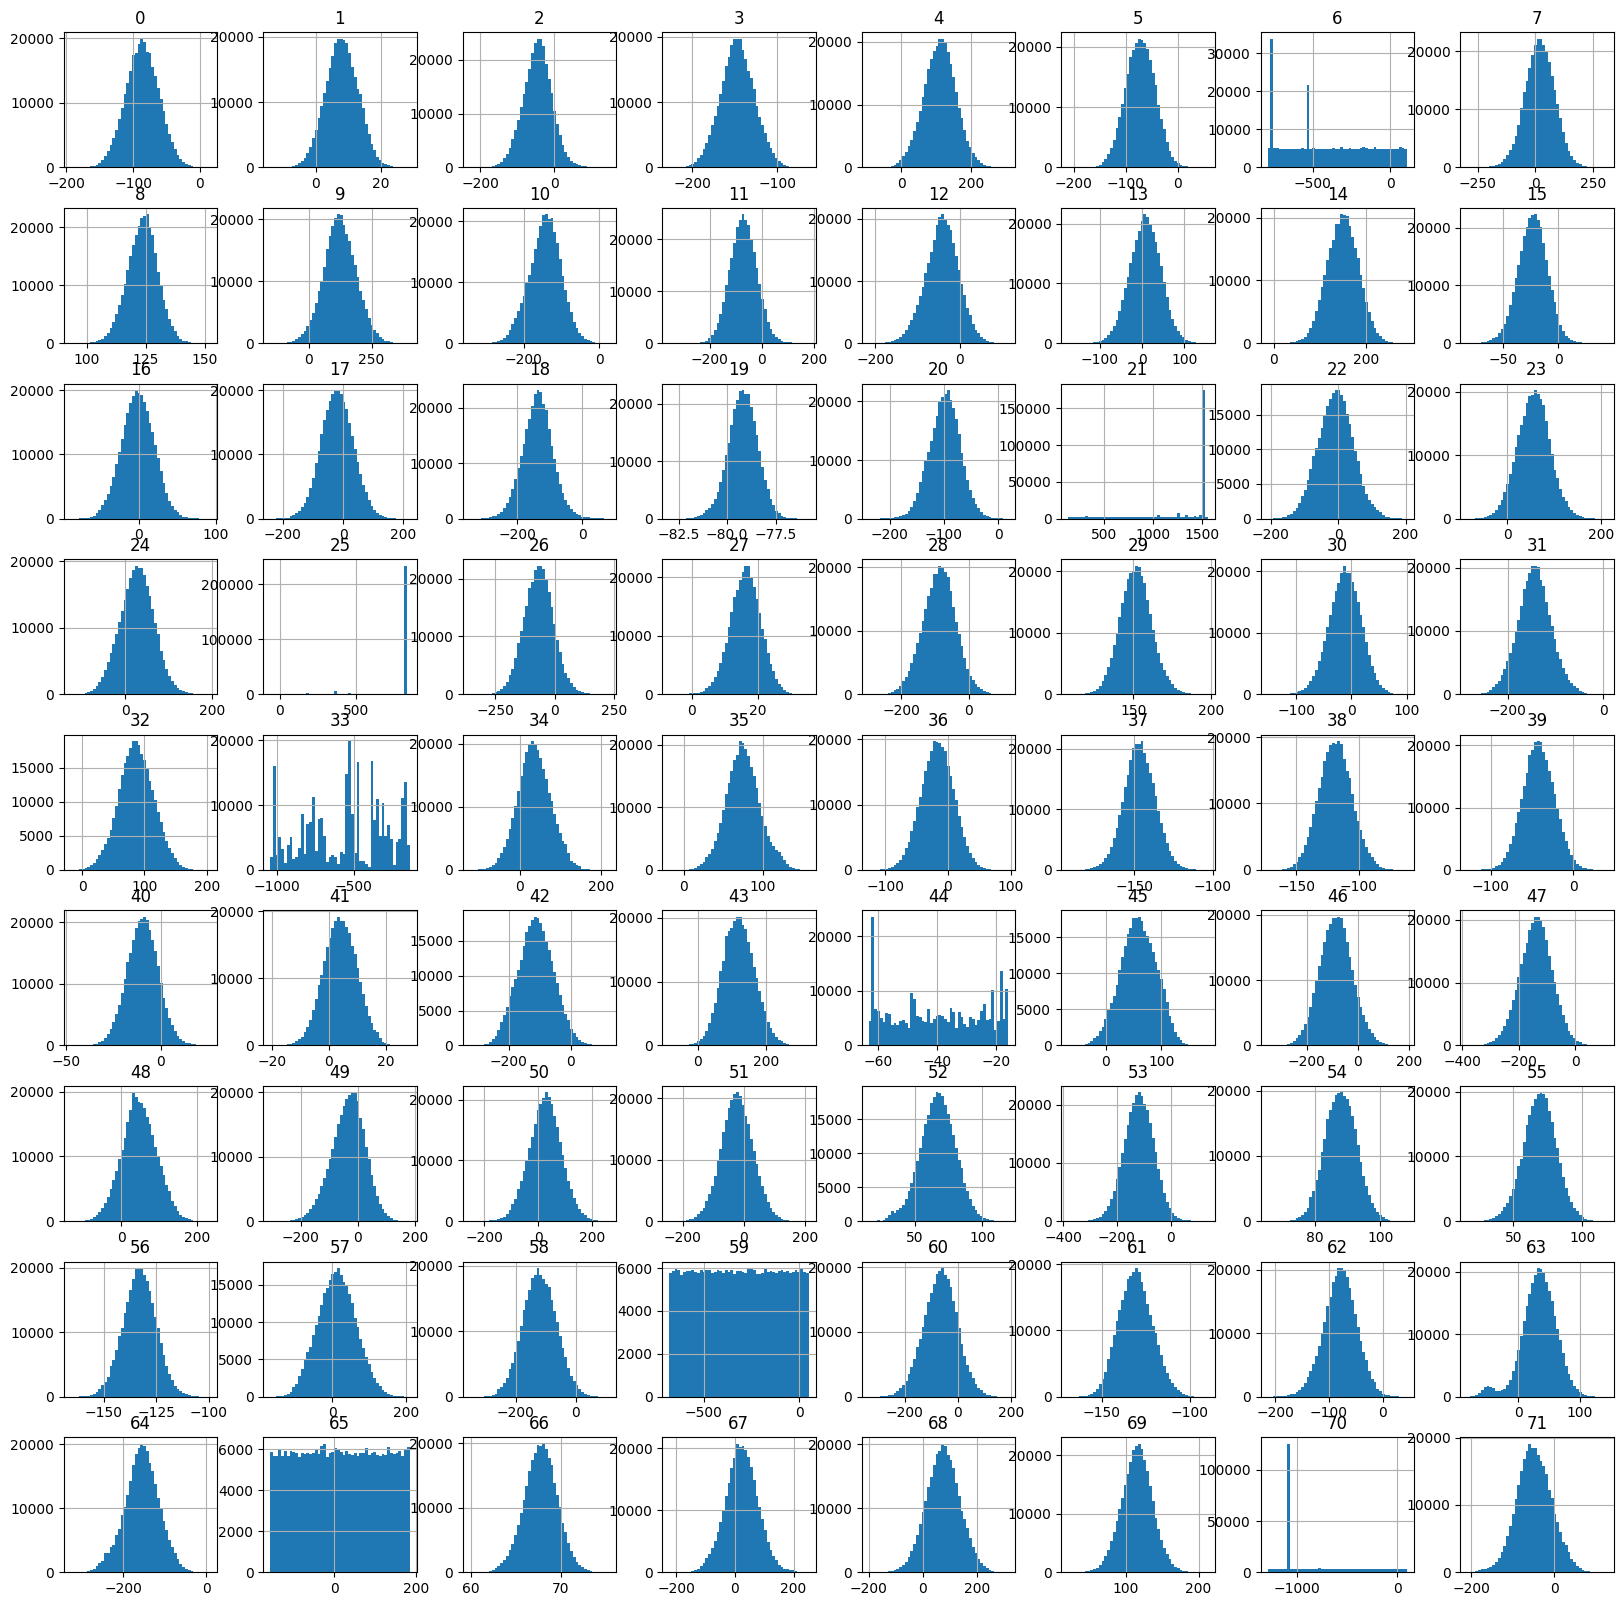

In [ ]:
get_eda_plots(df=df_base, name='df_base', sample_frac=.1)

#### Вывод доп. информации.

In [ ]:
df_base.sample(frac=.1, random_state=SEED).describe()

#### Вывод матриц корреляции.
- Выведем матрицы линейной корреляции только для основного датафрейма `df_base`, т.к. остальные два являются подвыборками.

In [ ]:
# Определим треугольную маску выводимых значений и цветовую схему.
mask_corr = np.triu(np.ones_like(df_train.corr(numeric_only=True), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Выведем матрицы корреляции с коэфф. Пирсона.
plt.figure(figsize=(10, 10))
sns.heatmap(df_base.corr(numeric_only=True), mask=mask_corr, cmap=cmap,
            vmax=1, vmin=-1, square=True, linewidths=.7, cbar_kws={"shrink": .5})
plt.title(f'Матрица корреляции.\nОсновная выборка - "df_base".\nКоэффициенты Пирсона.')
plt.show();

#### Проверка признаков на дискретность.
- Проверим признаки на дискретность, т.к. по графикам видны превалирующие значения в некоторых признаках.

In [ ]:
unique_ratio  = (df_base.nunique() / df_base.shape[0])
print('Признаки с менее 10% уникальных значений:')
unique_ratio[unique_ratio < .1].map('{:.2%}'.format)

### Ознакомление с данными, ИАД. Вывод.
- Размер датасетов:
  - `df_base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_val`: 100000 X 72 с идентификаторами объектов в индексе;
  - `df_val_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
<br><br>
- __Формат признаков.__
  - Формат признаков соответствует содержанию.
<br><br>
- __Пропуски и дубликаты.__
  - Данные не имеют пропусков и дубликатов за исключением дубликатов списка ответов валидационной выборки `df_val_answer`, которые означают, что одному товару могут соответствовать несколько.
<br><br>
- __Распределение признаков.__
  - Признаки имеют различный масштаб.
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному.
<br><br>
- __Выбросы / аномалии.__
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов.
  - Признаки 33 и 44 дискретны, возможно категориальны, т.к. имеют менее 1% и 2% уникальнах значений соответственно.
<br><br>
- __Корреляция признаков / мультиколлинеарность.__
  - Корреляция признаков отсутствует.

## Предобработка данных.

### Правка названий признаков.
- Переведём названия признаков и заголовков индексов в нижний регистр.

In [ ]:
for df in [df_base, df_train, df_val, df_val_answer]:
    df.index.name = df.index.name.lower()
for df in [df_train, df_val_answer]:
    df.columns = df.columns.str.lower()
for df, name in zip([df_base, df_train, df_val, df_val_answer],
                    ['df_base', 'df_train', 'df_val', 'df_val_answer']):
    print(name, ':')
    display(df.index.name)
    display(df.columns)
    print('~' * 70, '\n')

### Разделение `df_train`.
- Запишем ответы `target` обучающей выборки `df_train` в переменную `target_train` и удалим их из датафрейма.
- Проверим результат.

In [ ]:
# Запишем ответы обучающей выборки в переменную и удалим их из датафрейма.
target_train = df_train['target']
df_train.drop('target', axis=1, inplace=True)

# Проверим результат.
print('\033[1mВыделенный столбец с ответами для "df_train". Первые'+
      ' 5 строк.\033[0m')
display(target_train.head())
print('~' * 70, '\n')
print('\033[1mПризнаки датафрейма "df_train":')
display(df_train.columns)

## Базовые модели.
Для проведения тестов используем базовые модели `FAISS` и `ANNOY`, т.к. они значительно превосходят связку `KMeans` + `NearestNeighbors` в скорости.
- Принцип работы `FAISS`:
  - Создание инвертированного индекса.
  - Поиск похожих сначала по центроидам, затем по выбранным кластерам.
- Принцип работы `ANNOY`:
  - Создание индекса из леса бинарных деревьев, состоящих из итеративно разделенённых равноудалёнными гиперплоскостями пространств.
  - Поиск похожих спуском по деревьям со сравнением узлов с искомым вектором.<br>

### Функция вычисления accuracy@5 для `FAISS`, `ANNOY`.

Введём функцию, которая
- примет на вход
  - датафрейм со всеми объектами для составления индексов;
  - датафрейм с объектами для поиска похожих;
  - признак с ответами - разметкой предыдущего датафрейма;
  - тип модели: `FAISS`, `ANNOY`;
  - для модели `FAISS`:
    - кол-во кластеров;
    - тип индекса: `IVFFLAT` или `IVFHNSWFLAT`;
    - метрику (макс. скалярное произведение) / тип оцениваемого расстояния (Евклидово, Махаланобиса, косинусное);
    - размер выборки для обучения;
    - кол-во признаков в результирующем датафрейме, которое является меткой необходимости снижения размерности встроенным методом `PCA`;
    - кол-во похожих, используемых как точки входа для индекса `IVFHNSWFLAT`;
  - для модели `ANNOY`:
    - тип оцениваемого расстояния (Евклидово, Махаланобиса, Манхэеттенское, Хэмминга, косинусное) / метрику (скалярное произведение);
    - кол-во деревьев;
    - кол-во узлов для поиска;
  - кол-во искомых похожих объектов, в нашем случае `K=5`.
- создаст индекс(ы) для заданного расстояния и кол-ва кластеров / деревьев.
- вычислит и выведет целевую метрику `accuracy@k` для искомых k (в нашем случае `K=5`) похожих объектов для всех объектов переданного датафрейма и общее время поиска.

In [ ]:
# Функция вычисления целевой метрики accuracy@k.
def get_accuracy(df, df_eval, target,
                 model_type = None,
                 faiss_n_clust = None,
                 faiss_index = 'ivf_flat',
                 faiss_metric = 'euclidean',
                 faiss_train_sample_size = None,
                 faiss_pca_dims = None,
                 faiss_ef_search = 32,
                 annoy_distance_type = 'euclidean',
                 annoy_n_trees = 10,
                 annoy_search_n_nodes = -1,
                 k_similar = K,
                 SEED = 42):
    '''
    Builds index with specified model(s). Calculates accuracy@k.
    Arguments.
    - df : pd.DataFrame. Dataframe to find similars in.
    - df_eval : pd.DataFrame. Dataframe with samples to find similars for.
    - target : pd.Series or array. Columns with answers for df_eval.
    - model_type : str | list. Either 'faiss' or 'annoy' or both in list.
    - FAISS:
        - faiss_n_clust : int. Number of clusters for FAISS.
        - faiss_index : str. Type of index to build.
          Accepts:
        - 'ivf_flat' for IVFFlat index;
        - 'ivf_hnsw' for IVFHNSWFlat index with assignable number of clusters
          and entry points.
        - faiss_metric : str. Metric / distance type for FAISS.
          For IVFFLAT index accepts:
          - 'euclidean';
          - 'mahalanobis';
          - 'cosine';
          - 'mips' - maximum inner product search.
        - faiss_train_sample_size : int. FAISS train sample size.
        - faiss_pca_dims : int. If present, PCA dimensionality reduction is
          performed with the specified number of desired output features.
        - faiss_ef_search : int. Number of entry points for IVFHNSW index.
    - ANNOY:
        - annoy_distance_type : str.
          Accepts:
          - 'euclidean';
          - 'angular' for cosine distance;
          - 'manhattan';
          - 'hamming';
          - 'dot'.
        - annoy_n_trees : int. Number of trees for ANNOY index.
        - annoy_search_n_nodes : int. Number of nodes to search.
    - k_similar : int. Number of similar objects t search for.
    - SEED : any. RNG seed.
    '''

    # Изменим формат типа модели при необходимости.
    model_type = [model_type] if isinstance(model_type, str) else model_type

    # Определим длину вектора признаков.
    dims = df.shape[1]

    # Определим базовый индекс.
    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    # FAISS
    if 'faiss' in model_type:
        # FAISS с PCA
        if faiss_pca_dims:
            # Снизим размерность данных и приведём данные в соответстие faiss.
            pca_matrix = faiss.PCAMatrix(dims, faiss_pca_dims)
            pca_matrix.train(df)
            assert pca_matrix.is_trained
            df_arr = pca_matrix.apply(df)
            df_eval_arr = pca_matrix.apply(df_eval)

            dims = faiss_pca_dims

        # FAISS с индексом IVFFLAT.
        if faiss_index == 'ivf_flat':
            # Определим квантизатор.
            quantizer = faiss.IndexFlatL2(dims)

            # FAISS с расстоянием Махаланобиса.
            if faiss_metric == 'mahalanobis':
                if faiss_pca_dims:
                    df = df_arr
                    df_eval = df_eval_arr
                # Вычислим матрицу ковариации.
                df_c = df - df.mean(0)
                cov = np.dot(df_c.T, df_c) / df_c.shape[0]

                # Преобразуем ковариационную матрицу.
                L = np.linalg.cholesky(cov)
                mahalanobis_transform = np.linalg.inv(L)

                # Функция преобразования данных.
                def inverse_cholesky_cov(df, mahalanobis_transform):
                    df_trans = np.dot(df, mahalanobis_transform.T)
                    return df_trans.astype('float32')

                # Преобразуем данные.
                df_arr = inverse_cholesky_cov(df,
                                              mahalanobis_transform)
                df_eval_arr = inverse_cholesky_cov(df_eval,
                                                   mahalanobis_transform)

                # Определим индекс.
                faiss_index = faiss.IndexIVFFlat(quantizer,
                                                 dims,
                                                 faiss_n_clust,
                                                 faiss.METRIC_L2)

            else:
                if not faiss_pca_dims:
                    # Приведём данные в соответстие faiss.
                    df_arr = np.ascontiguousarray(df.values).astype('float32')
                    df_eval_arr = (
                        np.ascontiguousarray(df_eval.values).astype('float32')
                        )

                # FAISS с косинусным расстоянием.
                if faiss_metric == 'cosine':

                    # Нормализуем векторы.
                    faiss.normalize_L2(df_arr)
                    faiss.normalize_L2(df_eval_arr)

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust,
                                                    faiss.METRIC_INNER_PRODUCT)

                # FAISS с поиском максимального скалярного произведения.
                elif faiss_metric == 'mips':

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust,
                                                    faiss.METRIC_INNER_PRODUCT)

                # FAISS с Евклидовым расстоянием.
                elif faiss_metric == 'euclidean':

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust)

                else:
                    raise ValueError('Другие метрики "FAISS" не '+
                                     'поддерживаются.')

        # FAISS с индексом IVF_HNSW64.
        elif faiss_index == 'ivf_hnsw':
            # Приведём данные в соответстие faiss.
            df_arr = np.ascontiguousarray(df.values).astype('float32')
            df_eval_arr = (
                np.ascontiguousarray(df_eval.values).astype('float32')
                )

            # Определим индекс.
            faiss_index = faiss.index_factory(dims,
                                              (f'IVF{faiss_n_clust}_HNSW'+
                                               f'{faiss_ef_search}'+',Flat'))
            faiss_index.nprobe = 8

        start_faiss = perf_counter()

        faiss_index.train(df_arr[:faiss_train_sample_size, :])
        faiss_index.add(df_arr)

        # Построим индекс.
        vecs, idx = faiss_index.search(df_eval_arr, k_similar)

        # Вычислим целевую метрику accuracy@k для FAISS.
        acc_faiss = 0
        for t, el in zip(target.values.tolist(), idx):
            acc_faiss += int(t in [base_index[r] for r in el])

        # Вычислим время выполнения.
        time_faiss = perf_counter() - start_faiss

    # ANNOY
    if 'annoy' in model_type:

        # Определим индекс ANNOY.
        annoy_index = AnnoyIndex(dims, annoy_distance_type)
        annoy_index.set_seed(SEED)
        # Добавим векторы и их индексы.
        for i, v in zip(range(df.shape[0]), df.values):
            annoy_index.add_item(i, v)

        # Построим индекс.
        annoy_index.build(annoy_n_trees, n_jobs=-1)

        start_annoy = perf_counter()

        # Получим K похожих элементов для каждого запроса и собрём в список.
        idx = []
        for v in df_eval.values:
            idx.append(annoy_index.get_nns_by_vector(
                v,
                k_similar,
                search_k=annoy_search_n_nodes)
            )

        # Вычислим целевую метрику accuracy@k для ANNOY.
        acc_annoy = 0
        for t, el in zip(target.values.tolist(), idx):
            acc_annoy += int(t in [base_index[r] for r in el])

        # Вычислим время выполнения.
        time_annoy = perf_counter() - start_annoy

    # Выведем метрику и время исполнения для каждого/всех алгоритмов.
    if model_type == ['faiss']:
        return (round((100 * acc_faiss / len(idx)), 3),
                     round(time_faiss, 2))
    elif model_type == ['annoy']:
        return (round((100 * acc_annoy / len(idx)), 3), round(time_annoy, 2))
    elif all(model in model_type for model in ['faiss', 'annoy']):
        return (round((100 * acc_faiss / len(idx)), 3), round(time_faiss, 2),
                round((100 * acc_annoy / len(idx)), 3), round(time_annoy, 2))

### Базовые модели. Первичные оценки.
- Получим первичные значения целевой метрики `acuracy@5` на базовых моделях с произвольно выбранным кол-вами кластеров и деревьев для сравнения со значениями при проведении тестов.
- Размер выборки для обучения `FAISS` для всех тестов установим в не менее 10% от общего кол-ва объектов в основной выборке в соответствии с вычисленным ранее репрезентативным процентом выборки.

In [ ]:
%%time
# Получим первичные значения целевой метрики acuracy@5 на базовых моделях.
(acc_faiss, time_faiss,
 acc_annoy, time_annoy)  = get_accuracy(
      df=df_base, df_eval=df_train, target=target_train,
      model_type=['faiss', 'annoy'],
      faiss_n_clust = 100,
      faiss_train_sample_size = int(df_base.shape[0] * .1),
      annoy_n_trees = 50
      )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples((('Модель FAISS', 'accuracy@5:'),
                                    ('Модель FAISS', 'Время поиска (сек.):'),
                                    ('Модель ANNOY', 'accuracy@5:'),
                                    ('Модель ANNOY', 'Время поиска (сек.):')))

base_results = pd.DataFrame([[acc_faiss, time_faiss, acc_annoy, time_annoy]],
                           columns=columns)
display(base_results
        .style
        .format(precision=3)
        .set_caption('Первичные оценки базовых моделей.')
        .set_table_styles(styles))

#### Первичные оценки. Выводы.
- Значения целевой метрики для двух базовых алгоритмов оставляют желать лучшего. Проведём тесты и попытаемся улучшить эти значения.

### Тестирование разделимости дискретным признаком.
- Перед проведения других тестов, проверим целесообразность кластеризации по значениям дискретных признаков, т.к. такая кластеризация являлась бы наиболее осмысленной, если бы, например, категориальный признак "модель"/"цвет"/etc. естественно разделял бы товары на кластеры.
- Для теста, возьмём признак `33`, т.к. он обладает наименьшим кол-вом уникальных значений и является дискретным, а возможно и категориальным, с наибольшей вероятностью.
- В рамках теста
  - удалим ненормально распределённые признаки, кроме потенциального разделителя `33`;
  - смасштабируем признаки с помощью `RobustScaler`, устойчивого к выбросам;
  - cоздадим функцию вычисления целевой метрики, которая
    - сгруппирует данные в кластеры по уникаальным значениям признака `33`;
    - в каждом кластере найдёт 5 похожих для каждого объекта в `df_train`;
    - вычислит и выведет целевую метрику.

#### Функция кластеризации по значениям признака.

In [ ]:
def search_in_cluster_by_feature(df, df_eval, target, feature : str):
    '''
    Calculates accuracy@5 for clusters based on discrete feature unique values.
    '''
    # Соберём идентификаторы и кластеры в списки.
    centers_feat = []
    clusters_feat = []
    for center, cluster in df.groupby(feature):
        centers_feat.append(center)
        clusters_feat.append(cluster)

    # Определим экземпляр класса модели поиска похожих.
    nn_5 = NearestNeighbors(n_neighbors=(5))

    # clusters_feat[0]
    index_feat = []
    index_feat_final = []

    # Найдем похожие.
    print('Поиск похожих.', '\n', '-----')
    for row in tqdm(df_eval.values):
        i = 0
        for i in range(len(centers_feat)):
            if row[30] == centers_feat[i]:
                if clusters_feat[i].shape[0] >= K:
                    nn_5.fit(clusters_feat[i])
                    index_feat.append([i, nn_5.kneighbors(row.reshape(1,-1),
                                                          return_distance=False)])
                else:
                    index_feat.append([i, np.arange(clusters_feat[i].shape[0])])

    # Соберём похожие в список.
    print('\nСбор списка.', '\n', '-----')
    for i in tqdm([j[0] for j in index_feat]):
        k_similar = []
        for idx in clusters_feat[index_feat[i][0]].iloc[index_feat[i][1].ravel()].index:
            k_similar.append(df.index.get_loc(idx))
        index_feat_final.append(k_similar)

    # Определим базовый индекс.
    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    # Вычислим метрику.
    acc=0
    for t, el in zip(target_train.values.tolist(), index_feat_final):
        acc += int(t in [base_index[r] for r in el])

    return round(100 * acc / len(index_feat_final), 3)

#### Вычисление `accuracy@5` для кластеризации по признаку `33`.
- Удалим признаки с ненормальным распределением и смасштабируем остальные признаки.
- Вычислим `accuracy@5` для кластеризации по признаку `33`.

In [ ]:
# Удалим признаки с ненормальным распределением.
cols = ['6', '21', '25', '44', '59', '65', '70']
df_base_t = df_base.drop(cols, axis=1)
df_train_t = df_train.drop(cols, axis=1)

# Cмасштабируем остальные признаки.
rs = RobustScaler()

df_base_t = pd.DataFrame(rs.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(rs.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Вычислим `accuracy@5` для кластеризации по признаку `33`.
acc_33 = search_in_cluster_by_feature(df_base_t,
                                      df_train_t,
                                      target_train, '33')

print('Целевая метрика "accuracy@5" при разделении по уникальным '+
      f'значениям признака "33": {acc_33}')

#### Разделимость дискретным признаком. Вывод.
- Вывод неутешителен:`accuracy@5` = 0, признак `33` не способен разделить данные на осмысленные кластеры.
- Продолжим тестирование.

### Базовые модели. Удаление признаков.
- Т.к. обработка признаков с ненормальным распределением и некоторым кол-вом часто встречающихся значений без понимания их происхождения представляется проблематичной, проверим метрику `accuracy@5` на базовых моделях при поочерёдном удалении признаков:
`6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`

In [ ]:
%%time
# Проверим метрику accuracy@5 на базовых моделях с поочерёдным удалением
# ненормальных признаков.
normal_feats_results_list = []
for col in tqdm(['6', '21', '25', '33', '44', '59', '65', '70']):
    df_base_t = df_base.drop(col, axis=1)
    df_train_t = df_train.drop(col, axis=1)

    # Получим значения целевой метрики acuracy@5 на базовых моделях.
    (acc_faiss, time_faiss,
     acc_annoy, time_annoy)  = get_accuracy(
          df=df_base_t, df_eval=df_train_t, target=target_train,
          model_type=['faiss', 'annoy'],
          faiss_n_clust = 100,
          faiss_train_sample_size = int(df_base.shape[0] * .1),
          annoy_n_trees = 50
          )

    normal_feats_results_list.append([col, acc_faiss,
                                      time_faiss, acc_annoy,
                                      time_annoy])

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель FAISS', 'Удалённые признаки:'),
     ('Модель FAISS', 'accuracy@5:'),
     ('Модель FAISS', 'Время поиска (сек.):'),
     ('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):')))

normal_feats_results = pd.DataFrame(normal_feats_results_list,
                                    columns=columns)
display(normal_feats_results
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей с удалением\n '+
                     'ненормально распределённых признаков.')
        .set_table_styles(styles))

#### Удаление признаков. Выводы.
- Признаки `6`, `70` необходимо попытаться сохранить, т.к. при их удалении целевая метрика сильно снижается и обработка признаков с ненормальным распределением без понимания их происхождения представляется проблематичной.
- Остальные признаки с ненормальным распределением, ухудшающие или не влияющие на целевую метрику, удалим.

### Тестирование методов масштабирования.
- Смасштабируем признаки, т.к. модели, измеряющие расстояние, в т.ч. `KMeans`, `NN` и `ANN` (`FAISS`,`ANNOY`), чувствительны к разному масштабу признаков.
- Протестируем следующие варианты масштабирования:
  - Вариант 1:
    - Удаление признаков с ненормальным распределением.
    - Масштабирование с использованием `RobustScaler`.
  - Вариант 2:
    - Трансформация распределения признаков `6`, `70` в нормальные с использованием `QuantileTransformer`.
    - Замена одномерных выбросов средним по признаку.
    - Масштабирование с помощью `StandardScaler`.

- Введём функцию замены одномерных выбросов средним по признаку, которая
  -  примет датафрейм и кол-во $\sigma$ для определения и замены выбросов(по умолчанию 2.7$\sigma$, в соответствии с диаграммой размаха);
  -  вернет преобразованный датафрейм.

In [ ]:
# Функция замены выбросов на средние значения.
def outliers_to_means(df, n_sigma=2.7):
    df.mask(~zscore(df).abs().lt(n_sigma), inplace=True)
    df = df.apply(lambda x: x.fillna(x.mean()))
    return df

- Вариант 1:
  - Удаление признаков с ненормальным распределением.
  - Масштабирование с использованием `RobustScaler`.

In [ ]:
%%time
# Запишем датафреймы с удаляемыми признаками в переменные.
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
df_base_t = df_base.drop(cols, axis=1)
df_train_t = df_train.drop(cols, axis=1)

# Зададим экземпляр класса алгоритма мастабирования.
rs = RobustScaler()

# Смасштабируем признаки и запишем их в датафреймы.
df_base_t = pd.DataFrame(rs.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(rs.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Получим значения целевой метрики acuracy@5.
(acc_faiss, time_faiss,
 acc_annoy, time_annoy)  = get_accuracy(
     df=df_base_t, df_eval=df_train_t,
     target=target_train,
     model_type=['faiss', 'annoy'],
     faiss_n_clust = 100,
     faiss_train_sample_size = int(df_base.shape[0] * .1),
     annoy_n_trees = 50
 )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель FAISS', 'Удалённые признаки:'),
     ('Модель FAISS', 'accuracy@5:'),
     ('Модель FAISS', 'Время поиска (сек.):'),
     ('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):'))
)

scale_results_1 = pd.DataFrame(
    [[cols, acc_faiss, time_faiss, acc_annoy, time_annoy]],
    columns=columns
)
display(scale_results_1
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей с удалением признаков. Вариант 1.')
        .set_table_styles(styles))

- Вариант 2:
  - Трансформация распределений признаков `6`, `70` в приближенные к нормальным с использованием `QuantileTransformer`.
  - Замена одномерных выбросов средним по признаку.
  - Масштабирование с помощью `StandardScaler`.

In [ ]:
%%time
# Запишем датафреймы с удаляемыми признаками в переменные.
cols = ['21', '25', '33', '44', '59', '65']
cols_to_qt = ['6', '70']
df_base_t = df_base.drop(cols, axis=1)
df_train_t = df_train.drop(cols, axis=1)

# Зададим экземпляр класса алгоритмов трансформации
# и мастабирования.
qt = QuantileTransformer(n_quantiles=10000,
                         output_distribution='normal',
                         random_state=SEED)
ss = StandardScaler()

# Переведём признаки 6 и 70 в распределение близкое к нормальному.
df_base_t[cols_to_qt] = pd.DataFrame(
    qt.fit_transform(df_base_t[cols_to_qt]),
    columns=cols_to_qt, index=df_base_t.index
)
df_train_t[cols_to_qt] = pd.DataFrame(
    qt.transform(df_train_t[cols_to_qt]),
    columns=cols_to_qt, index=df_train_t.index
)

# Удалим выбросы.
df_base_t = outliers_to_means(df_base_t)
df_train_t = outliers_to_means(df_train_t)

# Смаштабируем признаки.
df_base_t = pd.DataFrame(ss.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(ss.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Получим значения целевой метрики acuracy@5.
(acc_faiss, time_faiss,
 acc_annoy, time_annoy)  = get_accuracy(
      df=df_base_t, df_eval=df_train_t, target=target_train,
      model_type=['faiss', 'annoy'],
      faiss_n_clust = 100,
      faiss_train_sample_size = int(df_base.shape[0] * .1),
      annoy_n_trees = 50
      )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель FAISS', 'Удалённые признаки:'),
     ('Модель FAISS', 'accuracy@5:'),
     ('Модель FAISS', 'Время поиска (сек.):'),
     ('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):'))
)

scale_results_2 = pd.DataFrame(
    [[cols, acc_faiss, time_faiss, acc_annoy, time_annoy]],
    columns=columns
)
display(scale_results_2
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей с удалением признаков. Вариант 2.')
        .set_table_styles(styles))

### Масштабирование признаков.
- Остановимся на Варианте 1, масштабировании с использованием `RobustScaler` и удалении признаков с ненормальными распределениями, т.к. он показал лучший результат.
  - Удалим признаки, с ненормальным распределеним: `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`.
  - Смасштабируем признаки, используя `RobustScaler`, устойчивый к выбросам, методом `fit_transform` для основного датафрейма и `transform` для двух остальных.
  - Выведем гистограммы и диаграммы размаха результирующих датафреймов.
- Добавим к результирующим датафреймам окончание `_rs` для индикации изменений.
- Удалим временные переменные `df_base_t`, `df_train_t`.

In [ ]:
%%time
# Удалим признаки, с ненормальным распределеним.
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
df_base_rs = df_base.drop(cols, axis=1)
df_train_rs = df_train.drop(cols, axis=1)
df_val_rs = df_val.drop(cols, axis=1)

# Смасштабируем оставшиеся признаки.
rs = RobustScaler()
df_base_rs = pd.DataFrame(rs.fit_transform(df_base_rs),
                          columns=df_base_rs.columns,
                          index=df_base_rs.index)
df_train_rs = pd.DataFrame(rs.transform(df_train_rs),
                           columns=df_train_rs.columns,
                           index=df_train_rs.index)
df_val_rs = pd.DataFrame(rs.transform(df_val_rs),
                         columns=df_val_rs.columns,
                         index=df_val_rs.index)

# Выведем графики для подвыборки для вcех признаков
# основного датафреймаи и графики для остальных датафреймов.
get_eda_plots(df=df_base_rs,
              name='Основной датафрейм.',
              sample_frac=.1)
get_eda_plots(df=df_train_rs,
              name='Обучающий датафрейм.')
get_eda_plots(df=df_base_rs,
              name='Валидационный датафрейм.')

# Удалим временные переменные.
del [df_base_t, df_train_t]

### Базовые модели. Промежуточный вывод.
- Проведено удалени признаков с ненормальным распределением `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`.
- Проведено масштабирование с использованием `RobustScaler`.

## Вычисление оптимального кол-ва кластеров.
Найдём оптимальное кол-во кластеров - `n` итерацией алгоритма `KMeans` и
- методом "локтя": вычислением сумм квадратов внутрикластерных расстояний до центроида (параметр `inertia_` в `sklearn`) для каждого `n` и нахождением точки слома на графике;
- методом вычислениея коэффициента силуэта, `silhouette_score`, - меры схожести точки с другими в кластере, по сравнению с другими кластерами, по формуле: $S(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}}$ , где
  - $S(i)$ &nbsp;коэффициент силуэта для точки i,
  - $a(i)$ &nbsp;среднее расстояние между точкой i и другими точками её кластера,
  - $b(i)$ &nbsp;среднее расстояние между точкой i и точками ближайшего кластера.

### Функция построения графиков для коэффициентов метода "локтя" и силуэта.

In [ ]:
# Функция построения графиков для коэффициентов метода "локтя"
# и силуэта.
def get_k_plots(df : pd.DataFrame(),
                k_list : list,
                sample_size : None,
                seed = SEED):
    '''
    Calculates silhouette and sum of squared distance coefficients
    and plots them for each k.
    Arguments:
    - df: dataframe to evaluate.
    - model: KMeans / MiniBatchKMeans.
    - k_list: list of numbers of clusters to evaluate.
    - sample_size: int. sample size for silhouette coefficient.
    '''
    # Зададим списки для сбора коэфф.
    silhouette_avg = []
    sum_squared_dist = []

    # Вычислим коэффициенты.
    for ni in tqdm(k_list):
        # Инициализация KMeans / MiniBatchKMeans.
        if sample_size:
            cluster_k = MiniBatchKMeans(n_clusters=ni,
                                        init='k-means++',
                                        n_init='auto',
                                        batch_size=1536,
                                        random_state=seed)
            cluster_k.fit(df)
            # Запишем коэффициент силуэта.
            silhouette_avg.append(silhouette_score(df,
                                                   cluster_k.labels_,
                                                   sample_size=sample_size,
                                                   random_state=seed))
        else:
            cluster_k = KMeans(n_clusters=ni,
                               init='k-means++',
                               n_init='auto',
                               random_state=SEED)
            cluster_k.fit(df)

            # Запишем коэффициент силуэта.
            silhouette_avg.append(silhouette_score(df,
                                                   cluster_k.labels_,
                                                   random_state=seed))
        # Запишем сумму квадратов расстояний.
        sum_squared_dist.append(cluster_k.inertia_)

    # Выведем графики.
    plt.figure(figsize=(10, 10))
    plt.plot(k_list, silhouette_avg, 'x-')
    plt.plot(k_list, [el*1e-9 for el in sum_squared_dist], 'o-');
    # plt.axvline(x=50, ls=':')
    plt.legend(['Коэффициент силуэта.',
                'Сумма квадратов расстояний \n(1e-9).',
                'Оптимальное число кластеров.'])
    plt.xlabel('Кол-во кластеров.')
    plt.xticks(k_list)
    plt.ylabel('Коэффициенты.')
    plt.title('Поиск оптимального кол-ва кластеров.\n"Метод '+
              'локтя" и "коэфф. силуэта".')
    plt.show();

### Построение графиков для коэффициентов метода "локтя" и силуэта.
- Вызовем функцию и построим график.

In [ ]:
%%time
# Вызовем функцию и построим график.
get_k_plots(df_base_rs,
            sample_size = 25000,
            k_list=[5, 10, 25, 50, 100, 200, 400, 600, 1000])

#### Вычисление оптимального кол-ва кластеров. Промежуточный вывод.
- Т.к. на кривой значений сумм квадратов расстояний не наблюдается точка излома, определить оптимальное кол-во кластеров методом "локтя" не представляется возможным.
- Кривая коэффициента силуэта показывает максимум в районе 400 кластеров, но все значения слишком близки к 0, чтобы утверждать, что найдена удовлетворительная разделимость.
- Вычислим дополнительные коэффициенты кластеризации.

### Определение оптимального кол-ва кластеров через коэффициенты кластеризации.
- Создадим функцию вычисления коэффицента схожести кластеров Дэвиса-Болдина: меньше - лучше.
- Для экономии времени исполнения кода вычислим коэффициенты для `MiniBatchKMeans`, которые должны приближенно соответствовать коэффициентам для `KMeans`.

In [ ]:
# Вычисление оптимального кол-ва кластеров.
def get_clustering_coeff(df: pd.DataFrame(),
                         n_clusters: list,
                         model = KMeans,
                         seed = SEED):
    '''
    Calculates Davis-Bouldin coefficient for provided dataframe
    and numbers of clusters.
    '''
    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]

    print('Коэффициент схожести кластеров Девиса-Боулдина: '+
          'меньше - лучше, минимум = 0.')

    for ni in tqdm(n_clusters):
        # Инициализация KMeans / MiniBatchKMeans.
        if model == MiniBatchKMeans:
            cluster_k = MiniBatchKMeans(n_clusters=ni,
                                        init='k-means++',
                                        n_init='auto',
                                        batch_size=1536,
                                        random_state=seed).fit(df)
        elif model == KMeans:
            cluster_k = KMeans(n_clusters=ni,
                               init='k-means++',
                               n_init='auto',
                               random_state=seed).fit(df)

        # Разделим df на ni кластеров.
        db_score = davies_bouldin_score(df, cluster_k.labels_)
        print(f'{ni} кластеров: {round(db_score, 3)}.\n-----')

In [ ]:
%%time
get_clustering_coeff(df=df_base_rs,
                     n_clusters=[10, 20, 50, 100, 200,
                                 300, 400, 500, 1000],
                     model=MiniBatchKMeans)

### Вычисление оптимального кол-ва кластеров. Вывод.
- Одной из причин снижения коэффициента Девиса-Болдина с увеличением кол-ва кластеров, может быть большое оптимальное кол-во. Но, т.к.  технической возможности делить данные на такое кол-во кластеров нет, ограничимся перебором кол-в кластеров от 100 до 500 и деревьев от 50 до 100 в циклах.

## Тесты параметров `FAISS` / `ANNOY`.

### `FAISS`. Тест метрик и кол-в кластеров.

In [ ]:
%%time
# Зададим список для сбора данных.
metrics_results_1_list = []

# Соберём данные.
for n_clust, metric in product(
    [100, 200, 300],
    ['euclidean', 'mahalanobis', 'cosine', 'mips']
):
    # Получим значения целевой метрики acuracy@5.
    acc_faiss, time_faiss = get_accuracy(
        df = df_base_rs,
        df_eval = df_train_rs,
        target = target_train,
        model_type='faiss',
        faiss_n_clust = n_clust,
        faiss_metric = metric,
        faiss_train_sample_size = int(df_base.shape[0] * .1)
    )
    metrics_results_1_list.append([n_clust, metric,
                                   acc_faiss, time_faiss])

# Создадим и выведем таблицу с результатами.
columns = ['Кол-во кластеров:', 'Метрика:',
           'accuracy@5:', 'Время поиска (сек.):']
metrics_results_1 = pd.DataFrame(metrics_results_1_list[1:],
                                 columns=columns)
display(metrics_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование FAISS.')
        .set_table_styles(styles))

#### `FAISS`. Тест метрик и кол-в кластеров. Вывод.
- Приближенно оптимальное кол-во кластеров для `FAISS` - 100.
- Лучшая метрикаа - расстояние Махаланобиса.

### `FAISS`. Тест с `PCA`.

In [ ]:
%%time
# Тест FAISS с PCA.

# Зададим список для сбора данных.
pca_results_1_list = []

# Соберём данные.
for pca_dims in trange(30, 70, 10):
    # Получим значения целевой метрики acuracy@5.
    acc_faiss, time_faiss = get_accuracy(
        df = df_base_rs,
        df_eval = df_train_rs,
        target = target_train,
        model_type='faiss',
        faiss_n_clust = 100,
        faiss_metric = 'mahalanobis',
        faiss_pca_dims=pca_dims,
        faiss_train_sample_size = int(df_base_rs.shape[0] * .1)
    )
    pca_results_1_list.append([pca_dims, acc_faiss, time_faiss])

# Создадим и выведем таблицу с результатами.
columns = ['Итоговое кол-во признаков:',
           'accuracy@5:', 'Время поиска (сек.):']
pca_results_1 = pd.DataFrame(pca_results_1_list,
                                 columns=columns)

display(pca_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование FAISS.')
        .set_table_styles(styles))

#### `FAISS`. Тест с `PCA`. Вывод.
- Снижение размерности явно ускоряет процесс поиска, но снижает `accuracy@5` с 63.033 без `PCA` до 62.655 со снижением размерности для расстояния Махаланобиса.
- Продолжим тесты без применения `PCA`.

### `FAISS`. Тест индексов.

In [ ]:
%%time
# Зададим список для сбора данных.
index_results_1_list = []

# Соберём данные.
for index_type, n_clust in product(
    ['ivf_flat', 'ivf_hnsw'],
    [50, 100]
):
    # Получим значения целевой метрики acuracy@5.
    acc_faiss, time_faiss = get_accuracy(
        df = df_base_rs,
        df_eval = df_train_rs,
        target = target_train,
        model_type= 'faiss',
        faiss_index = index_type,
        faiss_n_clust = n_clust,
        faiss_train_sample_size = int(df_base.shape[0] * .1)
    )
    index_results_1_list.append([index_type, n_clust,
                                 acc_faiss, time_faiss])

# Создадим и выведем таблицу с результатами.
columns = ['Тип индекса:', 'Кол-во кластеров',
           'accuracy@5:', 'Время поиска (сек.):']
index_results_1 = pd.DataFrame(index_results_1_list,
                               columns=columns)
display(index_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование FAISS.')
        .set_table_styles(styles))

#### `FAISS`. Тест индексов. Вывод.
- Приближенно оптимальное кол-во кластеров для `FAISS` - 100 при адеватном времени поиска.
- Индекс `IVFHNSWFLAT` даёт значительный прирост целевой метрики.

### `ANNOY`. Тест параметров.

In [ ]:
%%time
# Зададим список для сбора данных.
trees_results_1_list = []

# Соберём данные.
for annoy_n_trees, annoy_search_n_nodes in product(
    [50, 100, 150],
    [100, 200]
):
    # Получим значения целевой метрики acuracy@5.
    acc_annoy, time_annoy = get_accuracy(
        df = df_base_rs,
        df_eval = df_train_rs,
        target = target_train,
        model_type= 'annoy',
        annoy_n_trees = annoy_n_trees,
        annoy_search_n_nodes = annoy_search_n_nodes
    )
    trees_results_1_list.append([annoy_n_trees,
                                 annoy_search_n_nodes,
                                 acc_annoy,
                                 time_annoy])

# Создадим и выведем таблицу с результатами.
columns = ['Кол-во деревьев:', 'Кол-во узлов для поиска',
           'accuracy@5:', 'Время поиска (сек.):']
trees_results_1 = pd.DataFrame(trees_results_1_list,
                               columns=columns)
display(trees_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование ANNOY.')
        .set_table_styles(styles))

### `FAISS` / `ANNOY`. Тест метрик. Вывод.
- Наивысшее значение целевой метрики `accuracy@5` 70.528 показала модель `FAISS`
  - с кол-вом кластеров 50;
  - индексом `IVFHNSWFLAT`;
  - на смасштабированный с помощью `RobustScaler` данных;
  - с удалением признаков, распределённых ненормально.

## Вложенный `KMeans` + `NearestNeighbors`.

In [ ]:
# Функция 3-уровневой кластеризации.
def nested_cluster_nn_search(df : pd.DataFrame, df_eval : pd.DataFrame,
                             n_clusters_1 = 10, n_clusters_2 = 100,
                             nn_sample_size = 100000, k = 5,
                             model = KMeans, seed = SEED, verbose = 1):
    '''
    Returns accuracy@k for given dataframes of vectors by
    - 3-layer clustering;
    - searching for k similar in centroids of both levels and resulting
      clusters using NearestNeighbors:
      1 neighbor for centroids on both levels, k neighbors for resulting
      clusters;
    - comparing indices to targets.

    - Arguments:
      - df: pd.DataFrame. Dataframe of vectors to get matches from.
      - df_eval: pd.DataFrame. Dataframe of vectors for matching.
      - n_clusters_1: int. Number of clusters for the 1st level.
      - n_clusters_2: int. Number of clusters for the 2nd level.
      - nn_sample_size: int. Number of vectors to find matches for.
      - k: int. Number of similar items to search for.
      - model: model class. Accepts KMeans or MiniBatchKMeans.
      - seed: any. Random numbers generator seed;
      - verbose: int. Verbosity. 1 - verbose. 0 - silent.
    '''

    if verbose > 0:
        def verboseprint(*args):
            for arg in args:
                print(arg),
            print
    else:
        verboseprint = lambda *a: None

    # Зададим списки для сбора кластеров и центроид.
    centroids_level_1 = []
    clusters_level_1 = []
    centroids_level_2 = []
    clusters_level_2 = []
    centroids_level_2_all = []

    verboseprint('Начало кластеризации.')
    verboseprint('-' * 10)

    clust_start = perf_counter()

    ## Кластеризация.
    # Создадим экземлпяры класса Kmeans для каждого уровня
    # кластеризации для подходящей модели.
    if model == KMeans:
        model_n1 = model(n_clusters=n_clusters_1,
                         init='k-means++', n_init='auto',
                         random_state=SEED)
        model_n2 = model(n_clusters=n_clusters_2,
                         init='k-means++', n_init='auto',
                         random_state=SEED)
    elif model == MiniBatchKMeans:
        model_n1 = model(n_clusters=n_clusters_1,
                         init='k-means++', n_init='auto',
                         batch_size=1536, random_state=SEED)
        model_n2 = model(n_clusters=n_clusters_2,
                         init='k-means++', n_init='auto',
                         batch_size=1536, random_state=SEED)

    # Получим центроиды первого и второго уровня и кластеры второго уровня.
    # Первый уровень кластеризации.
    clust_n1 = model_n1.fit(df)
    centroids_level_1 = clust_n1.cluster_centers_
    for i in trange(n_clusters_1):
        clusters_level_1.append(df[clust_n1.labels_ == i])
        # Второй уровень кластеризации.
        clust_n2 = model_n2.fit(df[clust_n1.labels_ == i])
        centroids_level_2.append(clust_n2.cluster_centers_)
        for j in range(n_clusters_2):
            centroids_level_2_all.append(clust_n2.cluster_centers_[j])
            clusters_level_2.append(
                df[clust_n1.labels_ == i][clust_n2.labels_ == j]
            )

    # Соберём центроиды первого и второго уровня и центроиды второго
    # и кластеры третьего уровня в группы.
    level_1_2 = []
    level_2_3 = []
    for i in range(n_clusters_1):
        level_1_2.append([centroids_level_1[i], centroids_level_2[i]])
    for i in range(n_clusters_1 * n_clusters_2):
        level_2_3.append([centroids_level_2_all[i], clusters_level_2[i]])

    clust_time = perf_counter() - clust_start

    verboseprint('~' * 70, '\n')
    verboseprint(f'Начало поиска {k} похожих для {nn_sample_size} векторов.')
    verboseprint('-' * 10)

    search_start = perf_counter()

    nn = NearestNeighbors(n_neighbors=1, radius=1.0)
    nn_k = NearestNeighbors(n_neighbors=k, radius=1.0)
    index_nn = []
    df_idxs_level_3 = []

    ## Поиск похожих.
    # Найдём индексы k похожих векторов для среза тестового датафрейма
    # размером nn_train_sample_size.
    for idx in trange(df_eval.iloc[:nn_sample_size].shape[0]):
        # Обучим модель и найдём похожие центроиды первого уровня.
        nn.fit([i[0] for i in level_1_2])
        index_level_1 = nn.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1),
            return_distance=False
        )

        # Обучим модель и найдём похожие центроиды второго уровня.
        nn.fit(level_1_2[int(index_level_1)][1])
        index_level_2 = nn.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1),
            return_distance=False
        )
        # Найдем индекс похожего центроида второго уровня для передачи
        final_centroid = level_1_2[int(index_level_1)][1][int(index_level_2)]
        for idx, el in enumerate([i[0] for i in level_2_3]):
            if np.array_equal(el, final_centroid):
                final_centroid_idx = idx

        nn_k.fit([i[1] for i in level_2_3][final_centroid_idx].values)
        index_level_3 = nn_k.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1),
            return_distance=False
        )

        df_idxs_level_3 = []
        for idxs_level_3 in np.squeeze(index_level_3):
            vector = (
                [i[1] for i in level_2_3][final_centroid_idx]
                .iloc[idxs_level_3]
            )
            df_idxs_level_3.append(
                df.index.get_loc(df.loc[df.eq(vector, 1).all(1)].index[0])
            )

        index_nn.append(df_idxs_level_3)

    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    acc = 0
    for t, el in zip(target_train.values.tolist(), index_nn):
        acc += int(t in [base_index[r] for r in el])

    search_time = perf_counter() - search_start

    verboseprint('\n', '-' * 10, 'Конец работы.')

    # Выведем метрику и время исполнения.
    return round(100 * acc / len(index_nn), 3), clust_time, search_time

In [ ]:
nested_cluster_nn_search(df_base_rs, df_train_rs,
                         n_clusters_1 = 10, n_clusters_2 = 10,
                         model=MiniBatchKMeans,
                         nn_sample_size=1000)

### Вложенный `KMeans` + `NearestNeighbors`. Вывод.
- Добиться сколько-нибудь значимой точности (0.1% на 10) за отведённое время добиться не удалось.
- Функция требует разделения на уровни кластеризации и общей оптимизации.

## Финальная модель. Тестирование.

In [ ]:
# %%time
# Получим значения целевой метрики acuracy@5.
acc_faiss, time_faiss = get_accuracy(
    df = df_base_rs,
    df_eval = df_val_rs,
    target = df_val_answer['expected'],
    model_type= 'faiss',
    faiss_index = 'ivf_hnsw',
    faiss_n_clust = 50,
    faiss_train_sample_size = int(df_base.shape[0] * .1)
)

# Создадим и выведем таблицу с результатами.
results = pd.DataFrame([['IVFHNSWFLAT', '50',
                        acc_faiss, time_faiss]],
                       columns=['Тип индекса:', 'Кол-во кластеров',
                                'accuracy@5:', 'Время поиска (сек.):'])
display(results
        .style
        .format(precision=3)
        .set_caption('Финальная модель.\nВалидационная выборка.')
        .set_table_styles(styles))

# Общий вывод.
## Результат работы.
  - Значение целевой метрики `accuracy@5` 70.4 было достигнуто с использованием модели `FAISS` с параметрами
    - с кол-вом кластеров 50;
    - индексом `IVFHNSWFLAT`;
  - на смасштабированных с помощью `RobustScaler` данных;
  - с удалением признаков, распределённых ненормально.

## Задача.
  - Был разработан алгоритм, который для всех товаров из `validation.csv` находит 5 похожих из `base.csv`.

## Использовавшиеся в тестировании модели.
`FAISS` / `ANNOY`.

## План работы.
- [Загрузка библиотек.](#Загрузка-библиотек.)
- [Установка параметров проекта.](#Установка-параметров-проекта.)
- [Ознакомление с данными, ИАД.](#Ознакомление-с-данными,-ИАД.)
- [Предобработка данных.](#Предобработка-данных.)
- [Базовые модели.](#Базовые-модели.)
- [Вычисление оптимального кол-ва кластеров.](#Вычисление-оптимального-кол-ва-кластеров.)
- [Тесты параметров `FAISS` / `ANNOY`.](#Тесты-параметров-FAISS-/-ANNOY.)
- [Вложенный `KMeans` + `NEarestNeighbors`.](#Вложенный-KMeans-+-NearestNeighbors.)



## Данные.
- Размер датасетов:
  - `df_base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_val`: 100000 X 72 с идентификаторами объектов в индексе;
  - `df_val_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
- Распределение признаков.
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному. <br>
  Из-за невозможности идентификации признаков и неэффективности преобразований распределений признаков с точки зрения целевой метрики, признаки с ненормальным распределением были удалены.
- Выбросы / аномалии.
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов. Удаление / замена выбросов средним не оказались эффективнымы.
- Признаки 33 и 44 дискретны, возможно категориальны, т.к. имеют менее 1% и 2% уникальнах значений соответственно. Была проведена тестовая кластеризация по признаку `33`, которая не оказалась эффективной.
- Корреляция признаков / мультиколлинеарность.
  - Корреляция признаков не обнаружена.
## Рекомендации / возможные направления улучшения точности мэтчинга.
  - Проведение более развёрнутого анализа кластеров / признаков.
  - Оптимизация реализации связки "простых" алгоритмов `KMeans` + `NearestNeigbors`.-KMeans-+-NearestNeighbors.)